In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>Note:</b> the raw code for this notebook is by default hidden for easier reading.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

# Setup

In [2]:
import torch
import Darwin as dw
import seaborn as sns

from torchvision import datasets, transforms
from bogus import atk
from ipywidgets  import interactive, fixed
from bokeh.io import output_notebook

output_notebook()
sns.set()

Loading BokehJS ...

In [3]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    telegram_credentials = file.read().split('\n')

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [5]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

In [6]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['relu'], 'mutate':0.2}
                   #['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [7]:
atk_func = atk()

# Run 

In [8]:
testing = dw.TournamentOptimizer(3, LAYER_SPACE, NET_SPACE, dw.randomize_network, 
                           dw.mutate_net, dw.NetFromBuildInfo, dw.train, dw.test,
                          train_loader, test_loader, atk_func.fgsm, telegram_credentials)

In [9]:
testing.step(generations=1, epochs=1, save=True, phone=False)

Generation 1 Population mean:983.0 max:1009

Top performers:
0: score:1009
1: score:982



# Plots

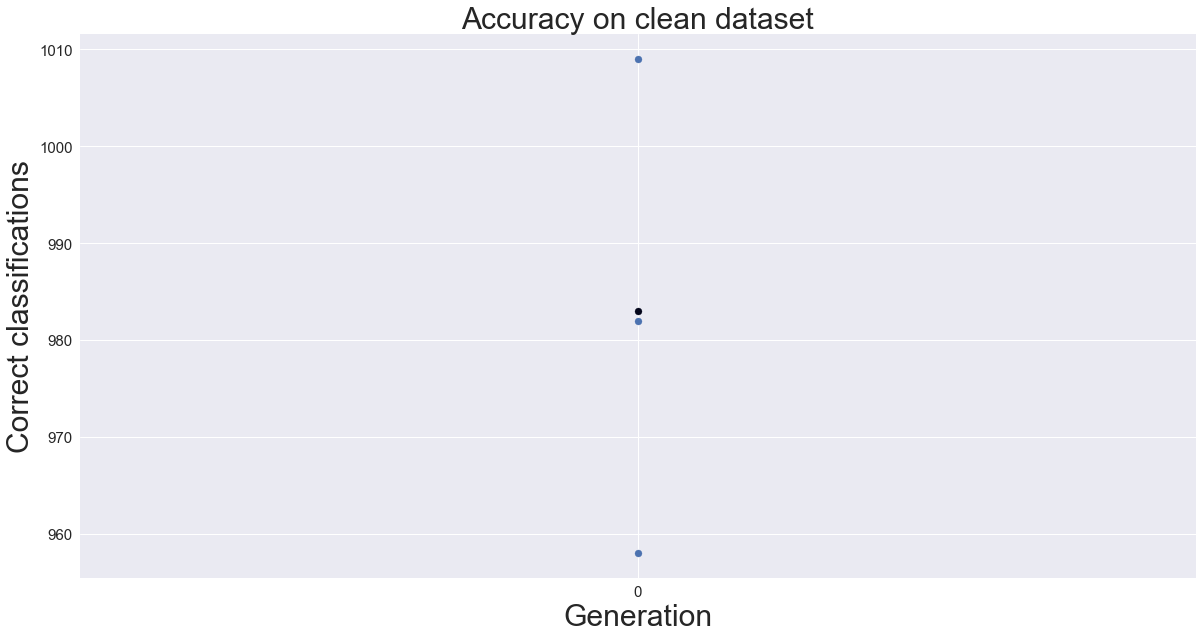

In [10]:
dw.progressplotter(testing, clean=True)

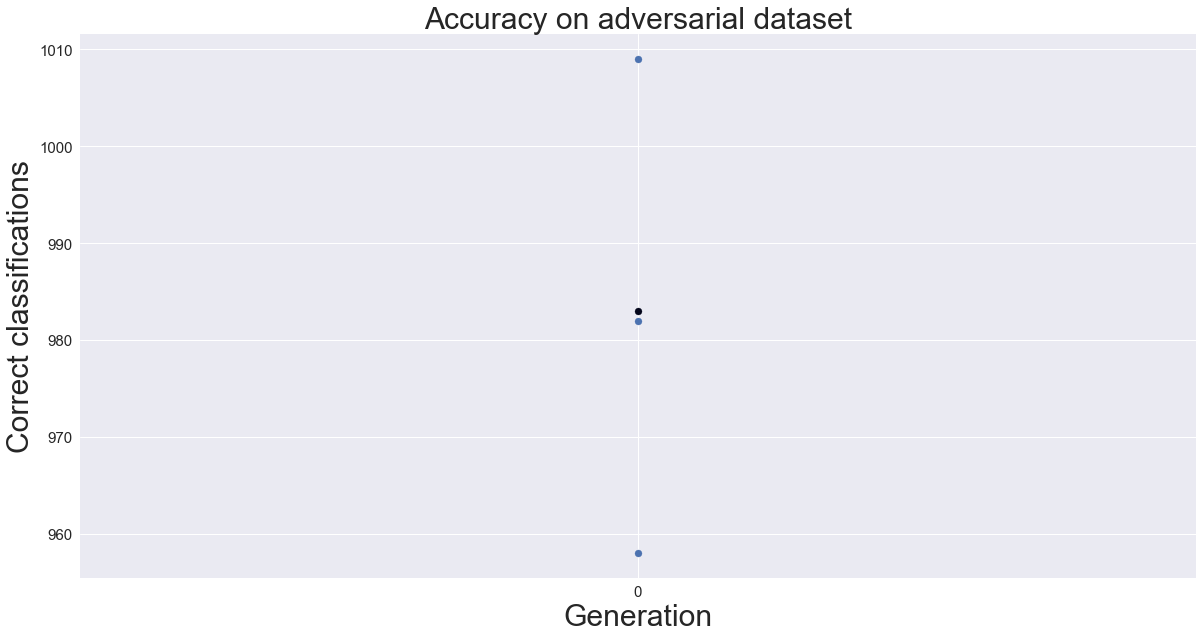

In [11]:
dw.progressplotter(testing)

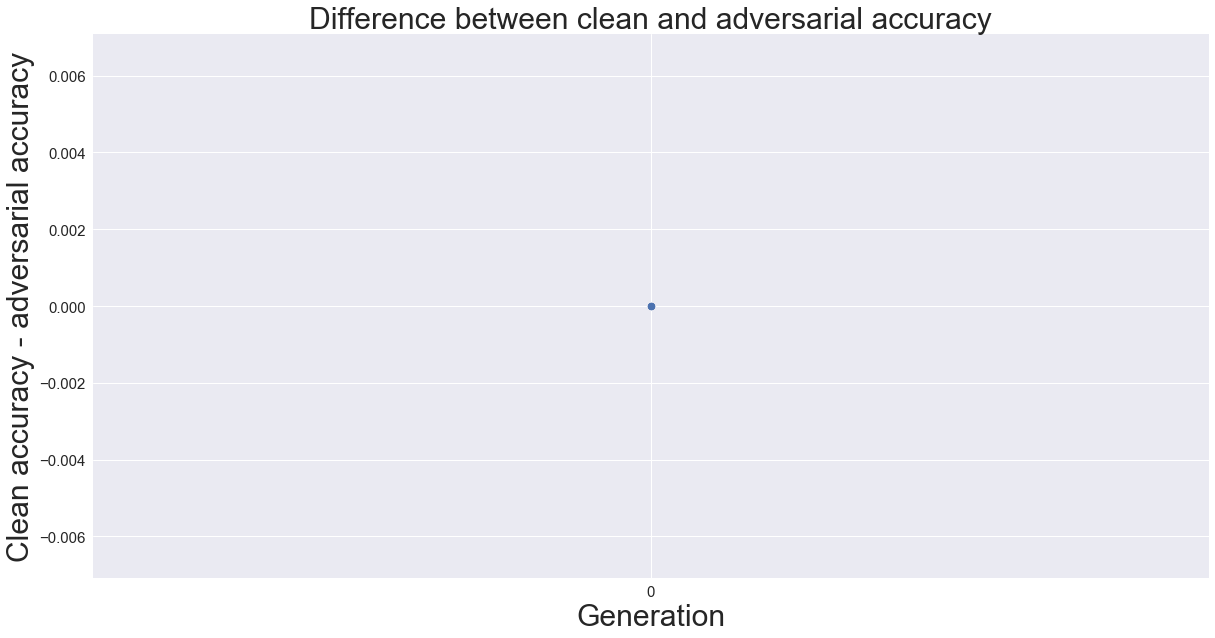

In [12]:
dw.diffplotter(testing)

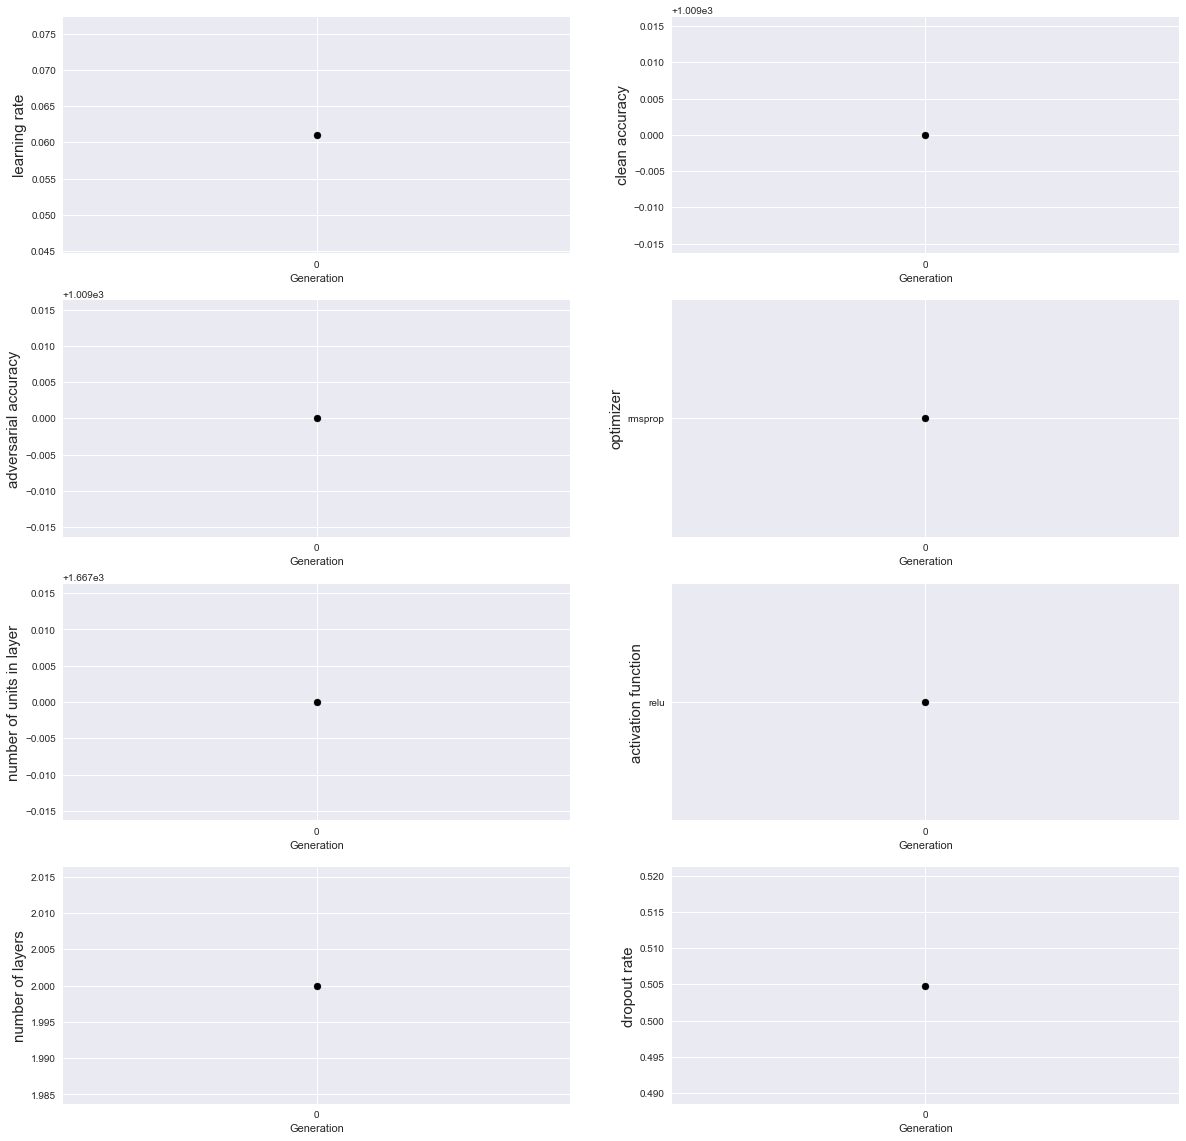

In [13]:
dw.bestplotter(testing, k=0)

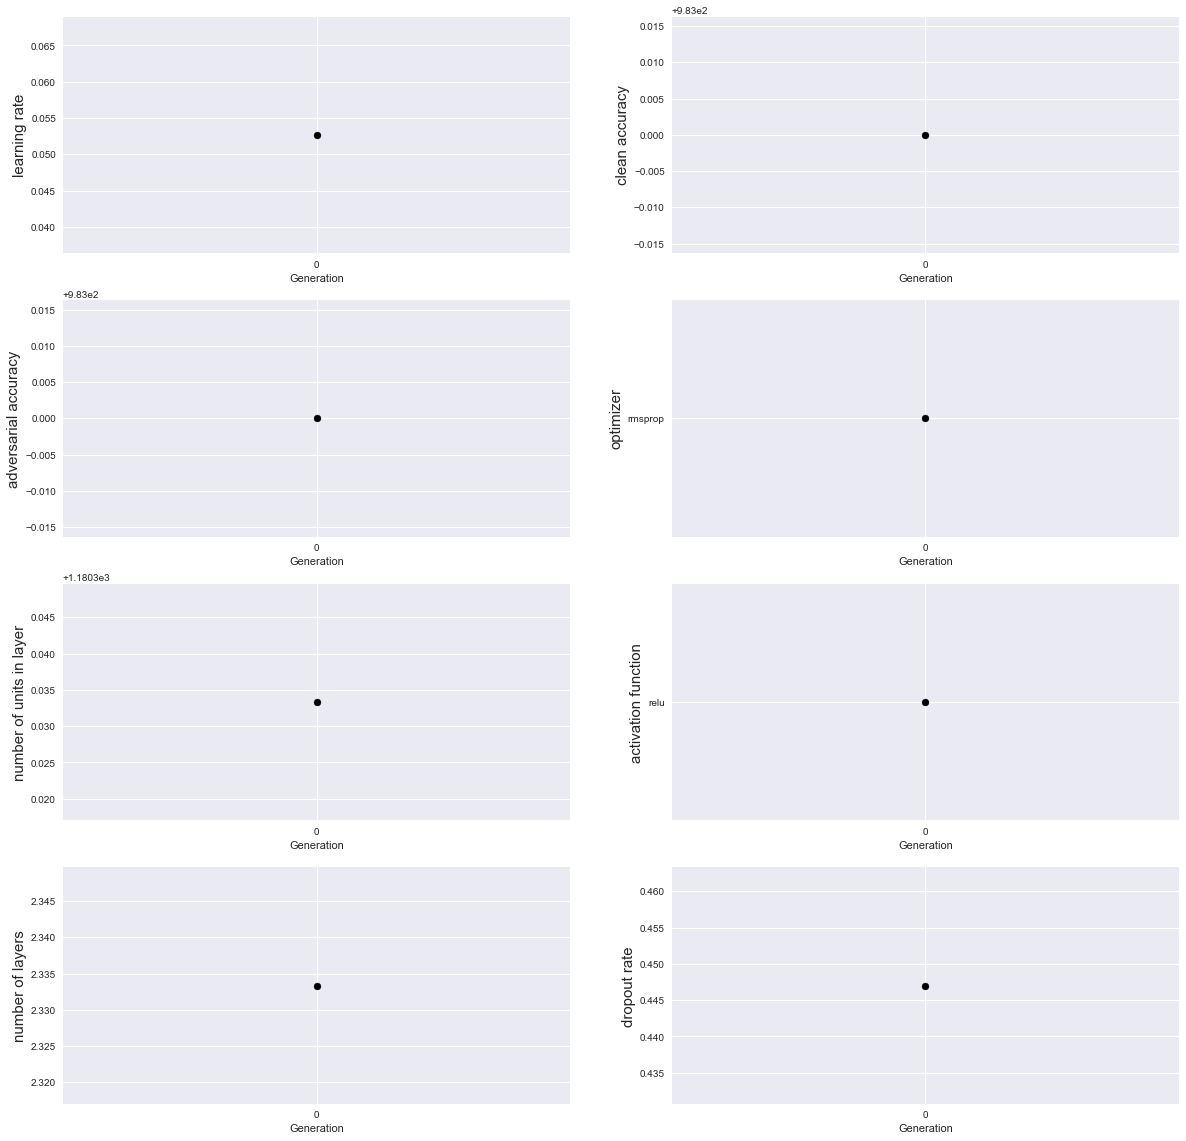

In [14]:
dw.avgplotter(testing)

In [15]:
dw.best_printer(testing)

,adversarial,clean,generation
best_adversarial,1009,1009,1
best_clean,1009,1009,1


Showing best model which was found in generation 1
Clean accuracy = 1009
adversarial accuracy =1009

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1667, bias=True)
    (dropout_0): Dropout(p=0.5048291275169713)
    (relu0): ReLU()
    (fc_1): Linear(in_features=1667, out_features=1253, bias=True)
    (dropout_1): Dropout(p=0.4430791627268471)
    (relu1): ReLU()
    (logits): Linear(in_features=1253, out_features=10, bias=True)
  )
) 

 Images below are adversarial
[[7.42891978e-39 1.61603789e-40 3.05148619e-66 8.69971625e-77
  1.74253679e-72 6.28153340e-67 2.70993352e-83 3.84157847e-73
  1.23049731e-60 1.00000000e+00]]
[[1.06560281e-37 5.66374680e-41 1.14184518e-65 5.37318008e-72
  1.27740250e-63 4.01425175e-63 3.95447070e-76 2.48150275e-70
  4.77685764e-58 1.00000000e+00]]
[[4.00778441e-055 3.67825071e-054 1.64907270e-082 2.84780043e-091
  8.09447196e-087 4.20835863e-083 8.17349254e-100 1.13244062e-085
  8

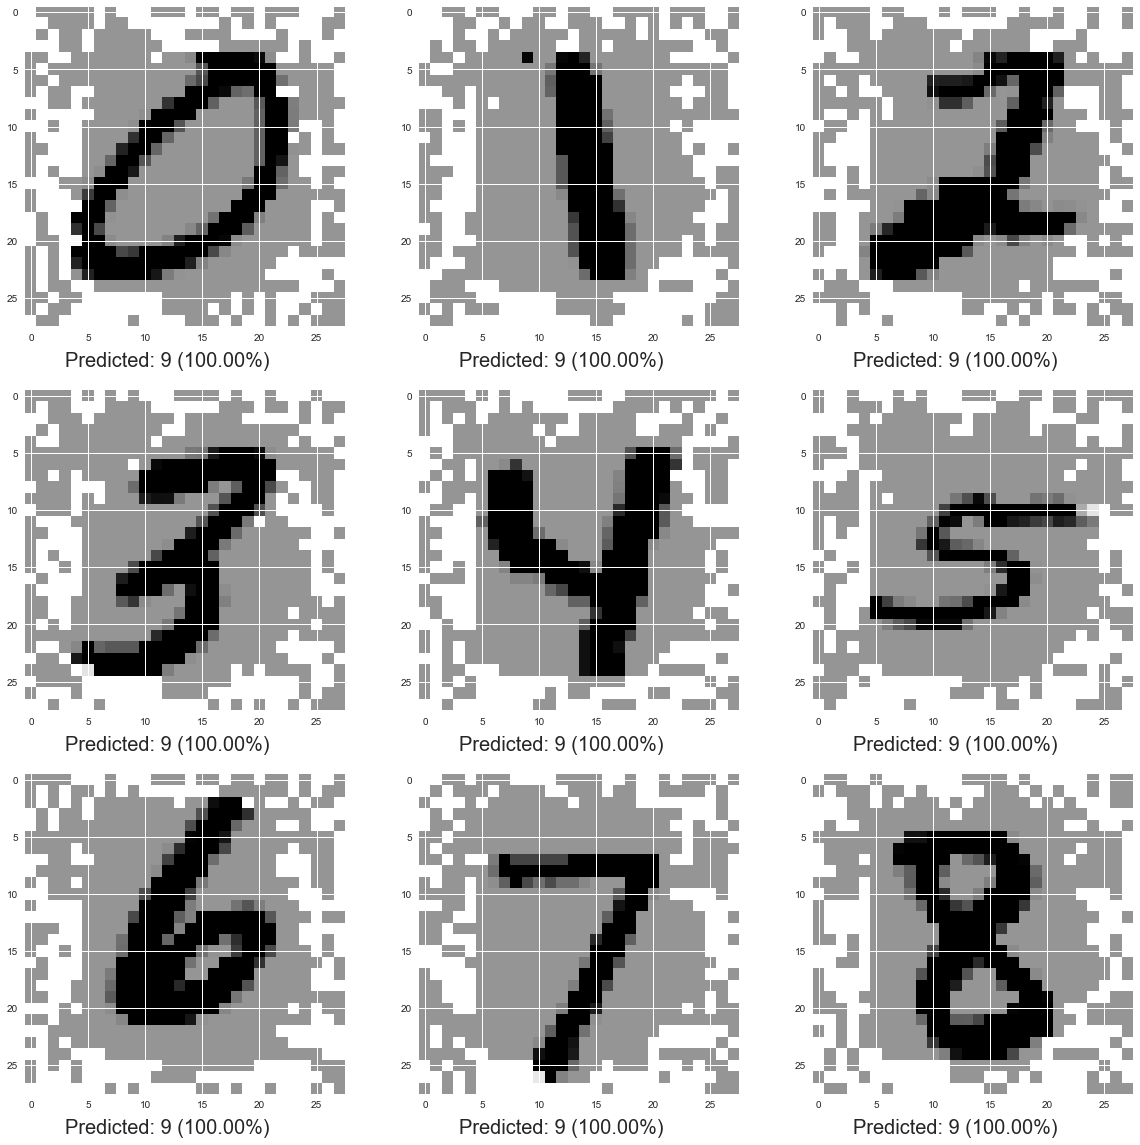

In [16]:
dw.multi_plot(testing, test_loader, adv_func=atk_func.fgsm, adversarial=True, eps=0.5)

Showing best model which was found in generation 1
Clean accuracy = 1009
adversarial accuracy =1009

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1667, bias=True)
    (dropout_0): Dropout(p=0.5048291275169713)
    (relu0): ReLU()
    (fc_1): Linear(in_features=1667, out_features=1253, bias=True)
    (dropout_1): Dropout(p=0.4430791627268471)
    (relu1): ReLU()
    (logits): Linear(in_features=1253, out_features=10, bias=True)
  )
) 

 Images below are clean
[[1.33517253e-34 6.33341536e-33 2.38097201e-57 5.06750157e-60
  3.30721219e-57 3.30234059e-56 1.51207931e-67 6.45446060e-57
  5.30007018e-60 1.00000000e+00]]
[[3.07119656e-06 2.70955702e-07 2.96597157e-10 3.58801498e-12
  9.64787023e-12 1.83914886e-10 1.43255819e-13 2.71851105e-11
  9.03937727e-11 9.99996657e-01]]
[[2.51706955e-26 1.27888528e-25 7.21343176e-44 1.67805139e-47
  9.18351553e-43 2.31466587e-38 3.17933428e-49 1.02870486e-37
  1.77487380e-41 

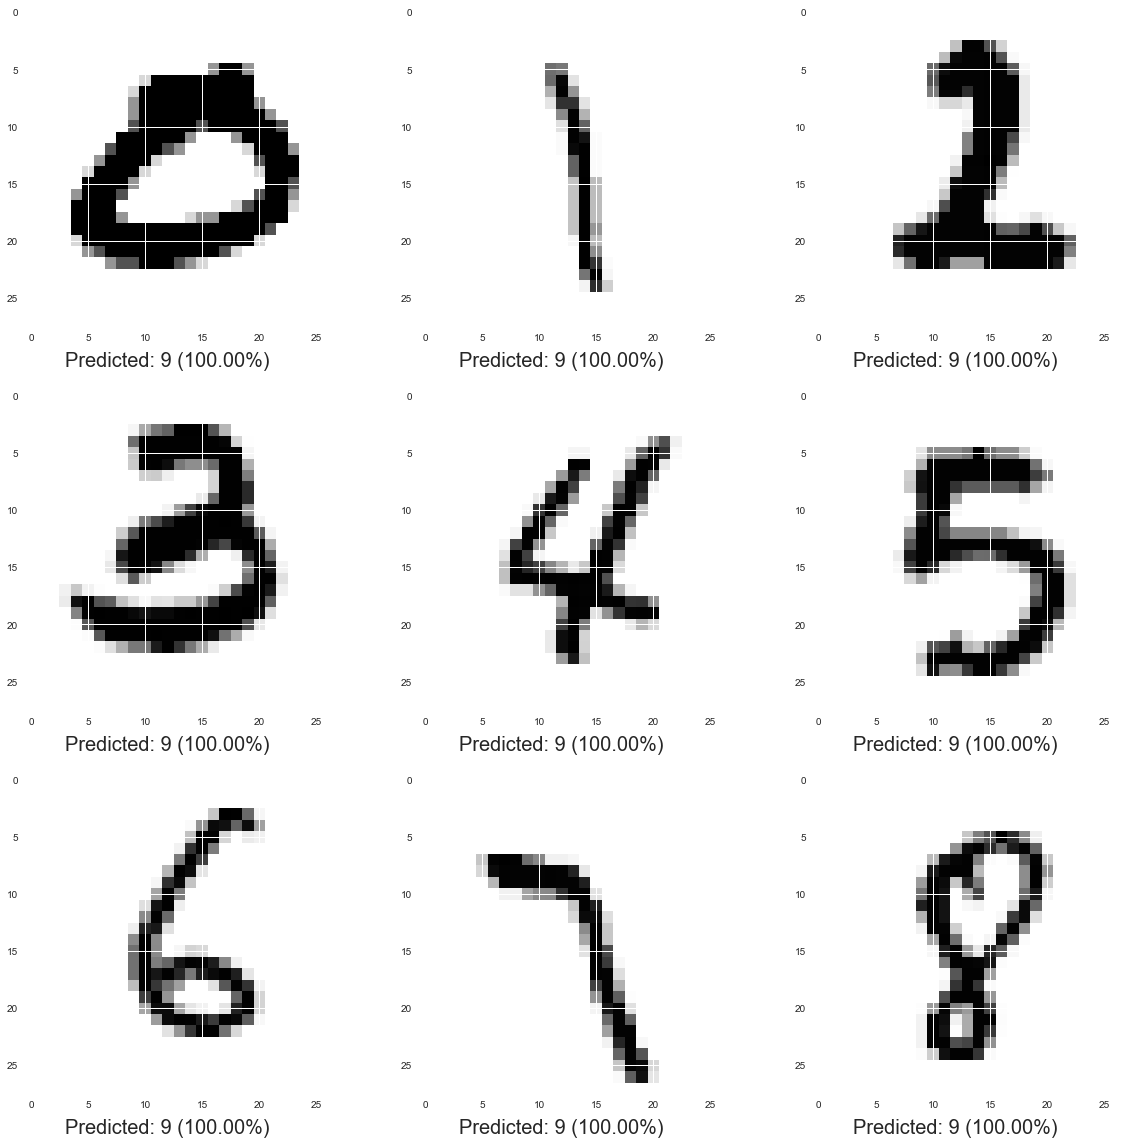

In [17]:
dw.multi_plot(testing, test_loader, adversarial=False)

In [18]:
df = dw.dataframer(testing)
#df.to_pickle(r"../data/neuroevolution4")

In [19]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(dw.int_plot, df=fixed(df), x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [20]:
interactive_plot #bokeh does not show on Github due to JS restrictions

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…

# Debugging

In [21]:
model = dw.rebuild_from_save(0,generation=3,position=4,run=1)

{'nb_layers': 2, 'layers': [{'activation': 'elu', 'dropout_rate': 0.6113715592706362, 'nb_units': 974}, {'activation': 'tanh', 'dropout_rate': 0.46057154559085706, 'nb_units': 612}], 'weight_decay': 1.9180935711755992e-05, 'optimizer': 'adam', 'lr': 0.028824730892500476}


[[0.19469022 0.00679594 0.05967071 0.12858796 0.02349352 0.17958551
  0.2982193  0.02259693 0.02640313 0.05995678]]
[[0.07585144 0.22340632 0.12473194 0.25617919 0.03925942 0.0335431
  0.20787953 0.00942583 0.00615518 0.02356805]]
[[0.12006675 0.00508885 0.19413514 0.01381612 0.00491709 0.11257078
  0.43555426 0.04293257 0.01839883 0.05251961]]
[[0.58263088 0.01878529 0.19735749 0.0228534  0.03698991 0.07020639
  0.02329645 0.00569815 0.02785835 0.01432371]]
[[0.15157706 0.02090312 0.04863035 0.19930534 0.04342302 0.02279165
  0.44083108 0.04858138 0.00671089 0.01724611]]
[[0.37853619 0.07204252 0.13904538 0.04625043 0.02034577 0.09386261
  0.13898278 0.05311104 0.00922829 0.04859499]]
[[0.65819444 0.01429105 0.0759831  0.01687575 0.00956073 0.02210574
  0.17474122 0.00268066 0.01137227 0.01419505]]
[[0.1333945  0.0312098  0.06719649 0.00800527 0.00886289 0.00131462
  0.71999535 0.02188416 0.00381524 0.00432169]]
[[0.01426643 0.4102368  0.06812661 0.04819624 0.0120211  0.14289418
  0.2

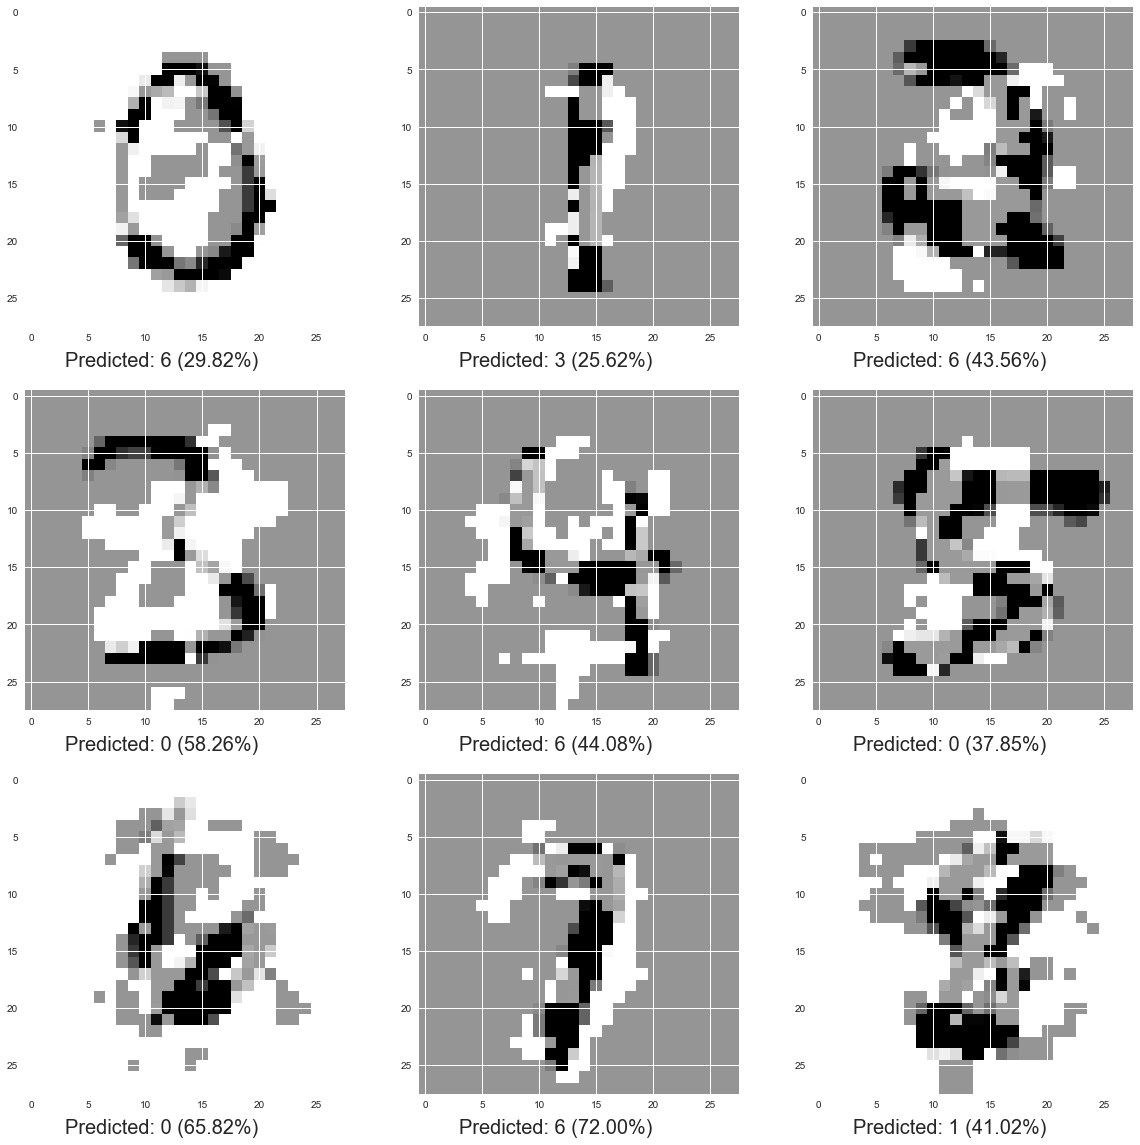

In [22]:
dw.multi_plot(testing, test_loader, adv_func=atk_func.fgsm, adversarial=True, eps=0.5, model=model)

In [23]:
model = dw.get_best_model(testing)[3]

In [24]:
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [25]:
batch = next(iter(test_loader))
img = batch[0][0].data
label = batch[1][0]

In [26]:
img.size()

torch.Size([1, 28, 28])

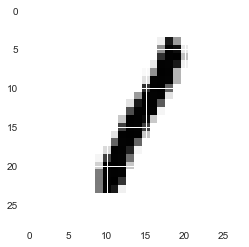

In [27]:
plt.imshow(img.numpy().reshape(28,28), cmap='Greys')

In [28]:
label

tensor(1)

In [29]:
grads = {}

In [30]:
def save_grad(name):  #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
    def hook(grad):
        grads[name] = grad
    return hook

In [31]:
grads['grad'].size()

KeyError: 'grad'

In [ ]:
x = Variable(img, requires_grad=True).cuda().double()

In [ ]:
x.register_hook(save_grad('grad'))

In [ ]:
h_adv = model(x)

In [ ]:
h_adv.shape

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
cost = criterion(h_adv, labels.cuda().view(1))

In [ ]:
cost.backward()

In [ ]:
h_adv

In [ ]:
h_adv[0].detach().cpu().numpy()

In [ ]:
np.exp(-215449.73)

In [ ]:
def fgsm(model, x, y, eps=0.3, x_val_min=0, x_val_max=1): #https://arxiv.org/pdf/1412.6572.pdf
        
    x_adv = Variable(x.data, requires_grad=True).cuda() #clean image
    x_adv.register_hook(self.save_grad('x_adv'))

    h_adv = model(x_adv) #clean pred

    cost = F.nll_loss(h_adv, y.cuda()) #negative log loss clean image and clean pred

    if x_adv.grad is not None:
        x_adv.grad.data.fill_(0)

    cost.backward()

    x_adv = x_adv + (eps*self.grads['x_adv'].sign())
    x_adv = torch.clamp(x_adv, x_val_min, x_val_max)


    return x_adv

In [ ]:
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    data= adv_func(model, data, target, eps=eps)
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(target.view_as(pred).cuda()).sum().item()
    test_loss += F.nll_loss(output, target, size_average=False).item()